# Problem statement:
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

# Importing Skin Cancer Data

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Importing all the important libraries

In [ ]:
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

In [ ]:
!unzip "/content/drive/MyDrive/CNN_assignment.zip" > /dev/null

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [ ]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

print("Total Images = " , (image_count_train + image_count_test))

2239
118
Total Images =  2357


# Create a dataset

In [ ]:
# Define some parameters for the loader:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
# train dataset
train_ds_non_aug = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
# validation dataset
val_ds_non_aug =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
class_names = train_ds_non_aug.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# Data Visualization

Found 2239 files belonging to 9 classes.


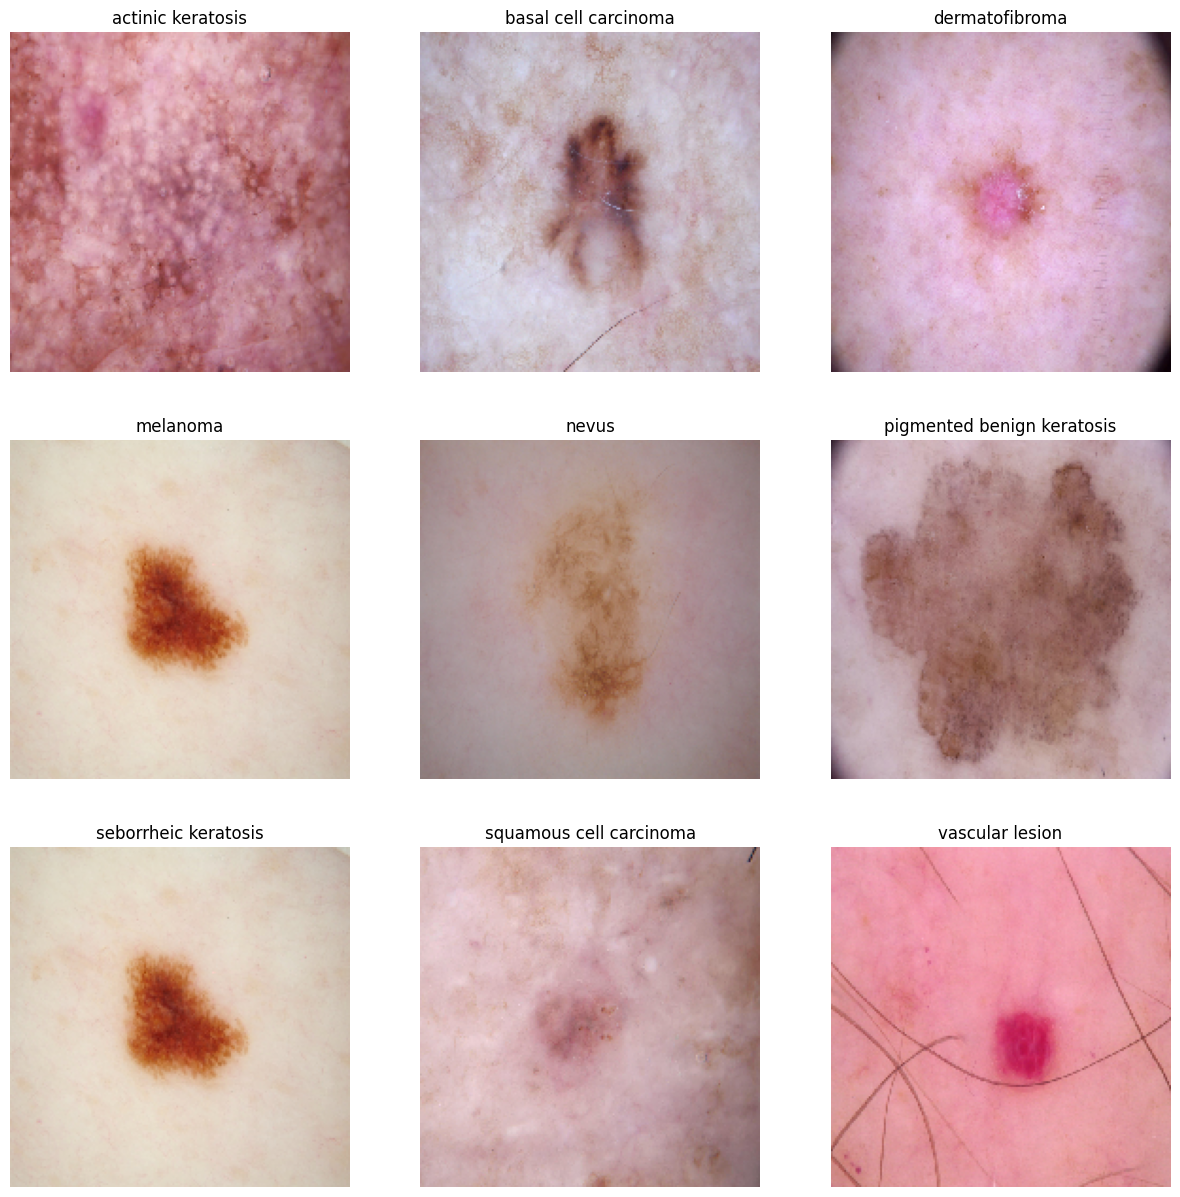

In [ ]:
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

### Visualize distribution of classes in the training dataset.

In [ ]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,squamous cell carcinoma,181
1,seborrheic keratosis,77
2,nevus,357
3,basal cell carcinoma,376
4,vascular lesion,139
5,melanoma,438
6,actinic keratosis,114
7,pigmented benign keratosis,462
8,dermatofibroma,95


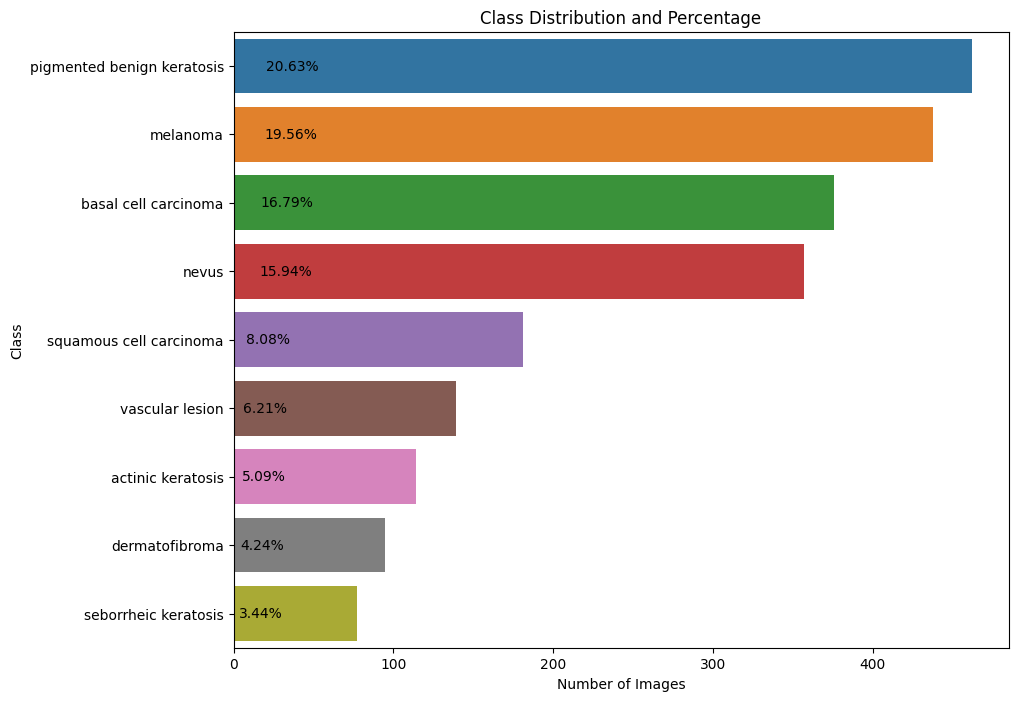

In [ ]:
import seaborn as sns

# Sort DataFrame by 'No. of Image' column in descending order
df = df.sort_values(by='No. of Image', ascending=False)

# Calculate the percentage of each class out of total images
total_images = df['No. of Image'].sum()
df['Percentage'] = (df['No. of Image'] / total_images) * 100

# Plot the bar chart
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df, order=df['Class'], label="Class")

# Display the percentage text on the bars
for index, value in enumerate(df['Percentage']):
    plt.text(value, index, f'{value:.2f}%', va='center', fontsize=10)

plt.xlabel("Number of Images")
plt.title("Class Distribution and Percentage")
plt.show()

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds_non_aug = train_ds_non_aug.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds_non_aug = val_ds_non_aug.cache().prefetch(buffer_size=AUTOTUNE)

# Create a CNN model

## CNN Model Architecture

In [ ]:

#Sequential allows you to create models layer-by-layer
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 41, 41, 128)      

### Visualizing the Model

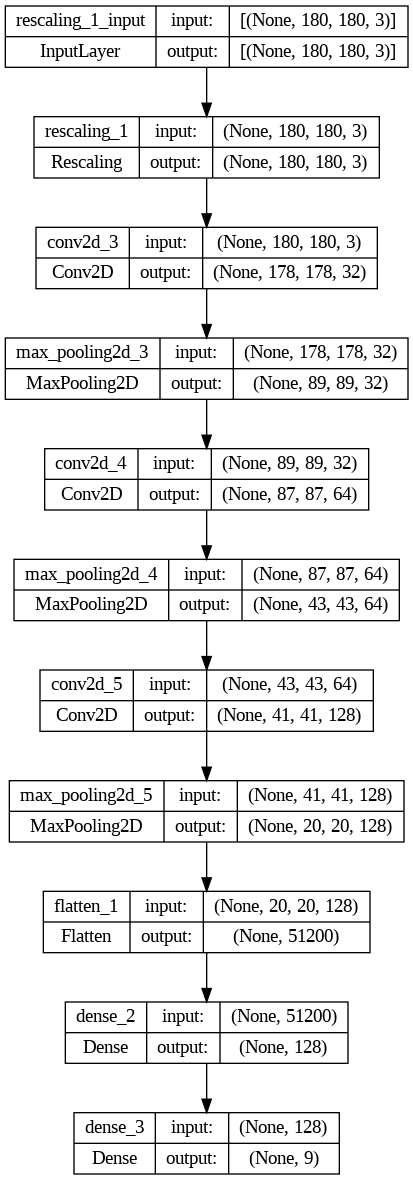

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Compile the Model

In [ ]:
#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

### Train the model

In [ ]:
epochs = 20
history = model.fit(train_ds_non_aug, validation_data=val_ds_non_aug, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/20
55/56 [============================>.] - ETA: 0s - loss: 2.0781 - accuracy: 0.2278
Epoch 1: val_accuracy improved from -inf to 0.30201, saving model to model.h5
56/56 [==============================] - 4s 51ms/step - loss: 2.0731 - accuracy: 0.2266 - val_loss: 1.8192 - val_accuracy: 0.3020
Epoch 2/20
55/56 [============================>.] - ETA: 0s - loss: 1.7890 - accuracy: 0.3591
Epoch 2: val_accuracy improved from 0.30201 to 0.42953, saving model to model.h5
56/56 [==============================] - 3s 46ms/step - loss: 1.7873 - accuracy: 0.3605 - val_loss: 1.6721 - val_accuracy: 0.4295
Epoch 3/20
55/56 [============================>.] - ETA: 0s - loss: 1.5172 - accuracy: 0.4699
Epoch 3: val_accuracy improved from 0.42953 to 0.52125, saving model to model.h5
56/56 [==============================] - 2s 42ms/step - loss: 1.5139 - accuracy: 0.4715 - val_loss: 1.4176 - val_accuracy: 0.5213
Epoch 4/20
55/56 [============================>.] - ETA: 0s - loss: 1.3900 - accuracy: 0

### Visualizing training results

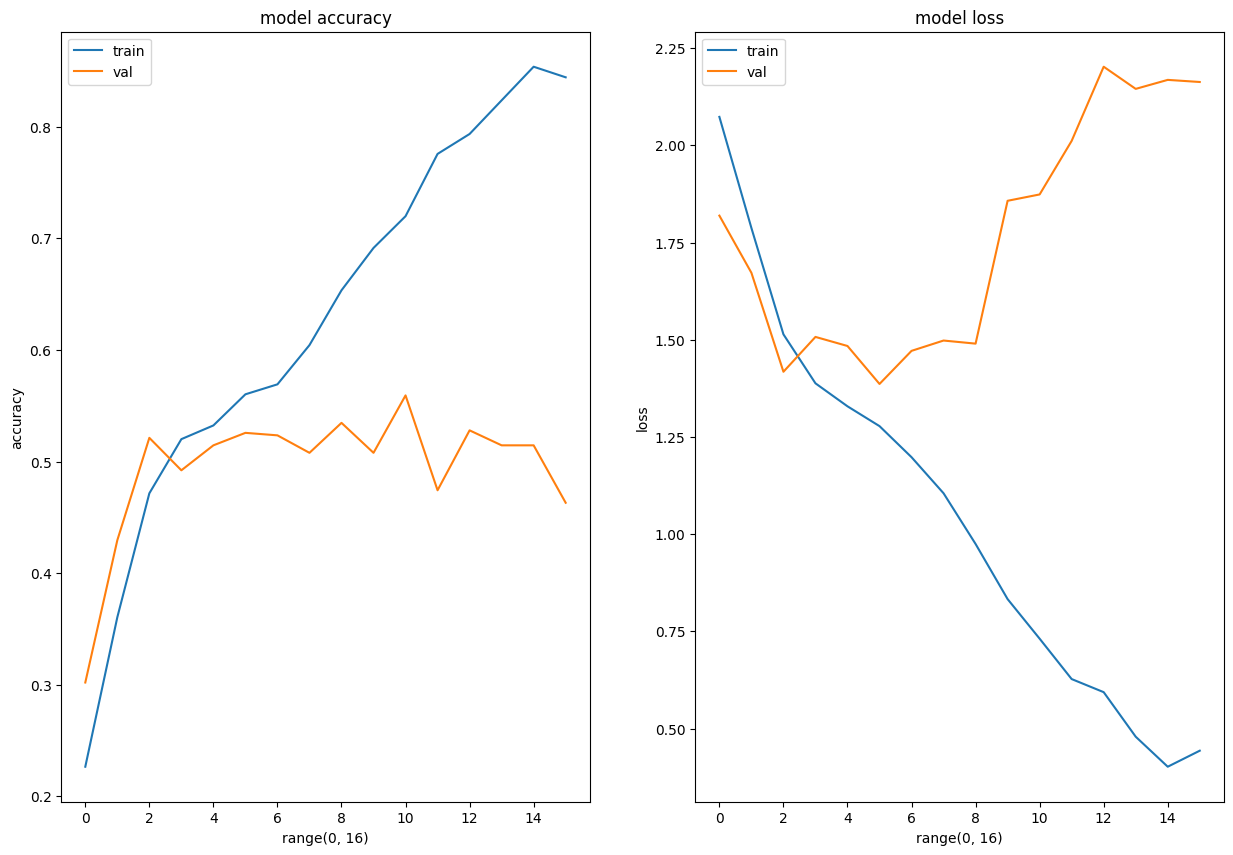

In [ ]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Observations:
1. There is Class imbalence in the provided data
2. The model tends to Overfit ( Model Accuracy on training data is 0.8443 where as same for the validation data is 0.55928 )

# CNN Model

### Model Architecture

In [ ]:

#Sequential allows you to create models layer-by-layer
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 41, 41, 128)      

### Compile the model

In [ ]:
#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

### Train the Model

In [ ]:
epochs = 20
history = model.fit(train_ds_non_aug, validation_data=val_ds_non_aug, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/20
56/56 [==============================] - ETA: 0s - loss: 1.9708 - accuracy: 0.2991
Epoch 1: val_accuracy improved from -inf to 0.31767, saving model to model.h5
56/56 [==============================] - 5s 64ms/step - loss: 1.9708 - accuracy: 0.2991 - val_loss: 1.8379 - val_accuracy: 0.3177
Epoch 2/20
56/56 [==============================] - ETA: 0s - loss: 1.5958 - accuracy: 0.4291
Epoch 2: val_accuracy improved from 0.31767 to 0.43848, saving model to model.h5
56/56 [==============================] - 4s 66ms/step - loss: 1.5958 - accuracy: 0.4291 - val_loss: 1.6445 - val_accuracy: 0.4385
Epoch 3/20
56/56 [==============================] - ETA: 0s - loss: 1.4932 - accuracy: 0.4782
Epoch 3: val_accuracy improved from 0.43848 to 0.53691, saving model to model.h5
56/56 [==============================] - 4s 65ms/step - loss: 1.4932 - accuracy: 0.4782 - val_loss: 1.3587 - val_accuracy: 0.5369
Epoch 4/20
56/56 [==============================] - ETA: 0s - loss: 1.3741 - accuracy: 0

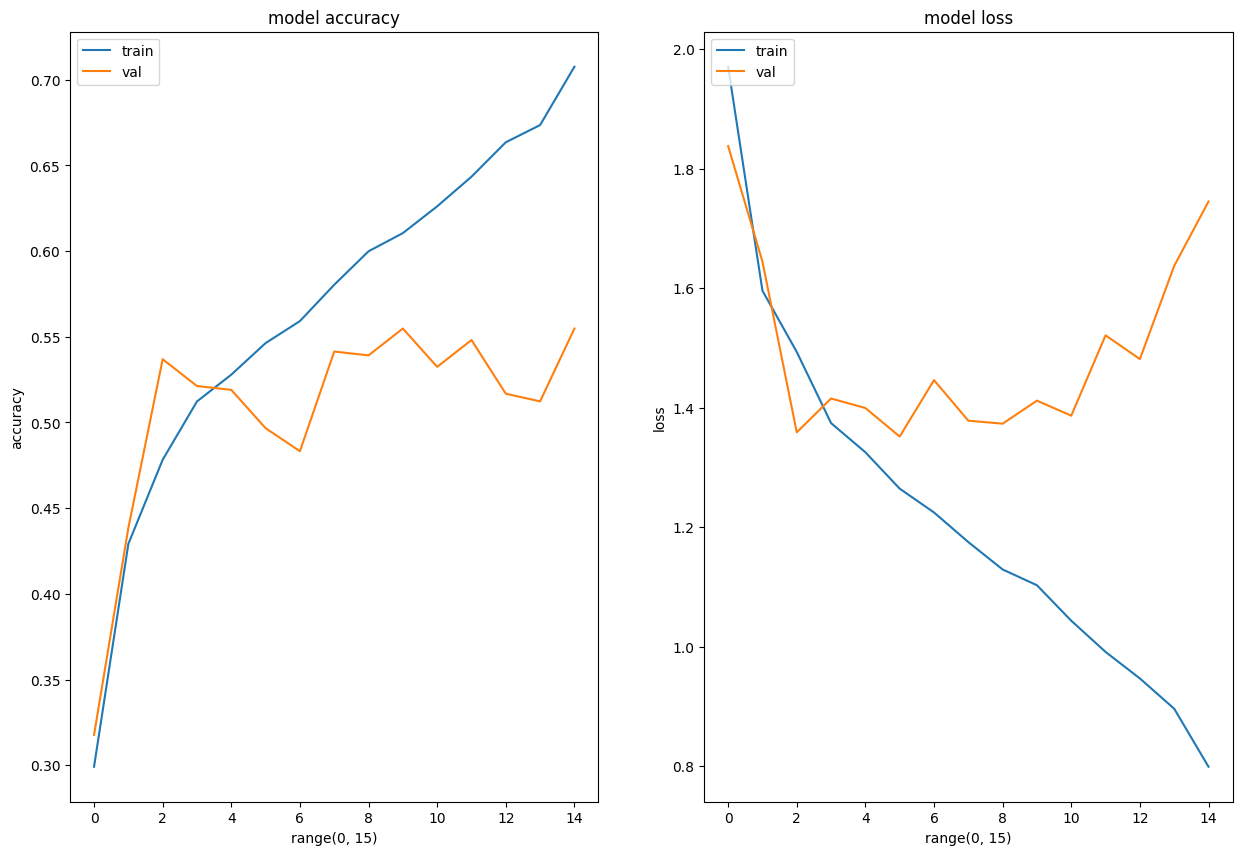

In [ ]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Class Imbalance
### Class 'pigmented benign keratosis' has highest number of images =>	462 images
### Class 'seborrheic keratosis' has least number of images =>	77 imahes

## Rectify the class imbalance

In [ ]:
#install Augmentor
!pip install Augmentor

In [ ]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x78421D89BDF0>: 100%|██████████| 500/500 [00:18<00:00, 26.52 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78421A187250>: 100%|██████████| 500/500 [00:20<00:00, 24.31 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78421D982C50>: 100%|██████████| 500/500 [00:20<00:00, 24.82 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x78429806B130>: 100%|██████████| 500/500 [01:24<00:00,  5.92 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=824x719 at 0x78429052F2B0>: 100%|██████████| 500/500 [01:07<00:00,  7.40 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78421A1B7D90>: 100%|██████████| 500/500 [00:15<00:00, 31.87 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x78421DCBE290>: 100%|██████████| 500/500 [00:37<00:00, 13.48 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78429B12EA70>: 100%|██████████| 500/500 [00:15<00:00, 33.11 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x784290595480>: 100%|██████████| 500/500 [00:22<00:00, 22.53 Samples/s]


In [ ]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [ ]:
def class_distribution_count(directory):
    # Count number of images in each class
    count = []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            # Check for the 'output' subfolder and count its contents
            output_path = os.path.join(path, 'output')
            count.append(len([name for name in os.listdir(output_path)
                              if os.path.isfile(os.path.join(output_path, name))]))

    # Name of the classes
    sub_directory = [name for name in os.listdir(directory)
                     if os.path.isdir(os.path.join(directory, name))]

    # Return DataFrame with image count and class
    df = pd.DataFrame(list(zip(sub_directory, count)), columns=['Class', 'No. of Images'])

    return df

In [ ]:
df2 = class_distribution_count(data_dir_train)
df2

,Class,No. of Images
0,squamous cell carcinoma,500
1,seborrheic keratosis,500
2,nevus,500
3,basal cell carcinoma,500
4,vascular lesion,500
5,melanoma,500
6,actinic keratosis,500
7,pigmented benign keratosis,500
8,dermatofibroma,500


In [ ]:
df

,Class,No. of Image,Percentage
7,pigmented benign keratosis,462,20.634212
5,melanoma,438,19.562305
3,basal cell carcinoma,376,16.793211
2,nevus,357,15.944618
0,squamous cell carcinoma,181,8.083966
4,vascular lesion,139,6.208129
6,actinic keratosis,114,5.091559
8,dermatofibroma,95,4.242966
1,seborrheic keratosis,77,3.439035


In [ ]:
df3 = pd.merge(df, df2, on='Class')
df3

,Class,No. of Image,Percentage,No. of Images
0,pigmented benign keratosis,462,20.634212,500
1,melanoma,438,19.562305,500
2,basal cell carcinoma,376,16.793211,500
3,nevus,357,15.944618,500
4,squamous cell carcinoma,181,8.083966,500
5,vascular lesion,139,6.208129,500
6,actinic keratosis,114,5.091559,500
7,dermatofibroma,95,4.242966,500
8,seborrheic keratosis,77,3.439035,500


# Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=batch_size,
                                                               image_size=(img_height,img_width), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [ ]:
# validation dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,
                                                            image_size=(img_height,img_width), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:

#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
#model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
#model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Fourth Convulation Layer
model.add(layers.Conv2D(256,kernel_size=(3,3),activation='relu'))
#model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

model.add(layers.BatchNormalization())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
#model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_12 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_41 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 batch_normalization_17 (Ba  (None, 178, 178, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_41 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_42 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_42 (MaxPooli  (None, 43, 43, 64)      

### Visualizing the Model

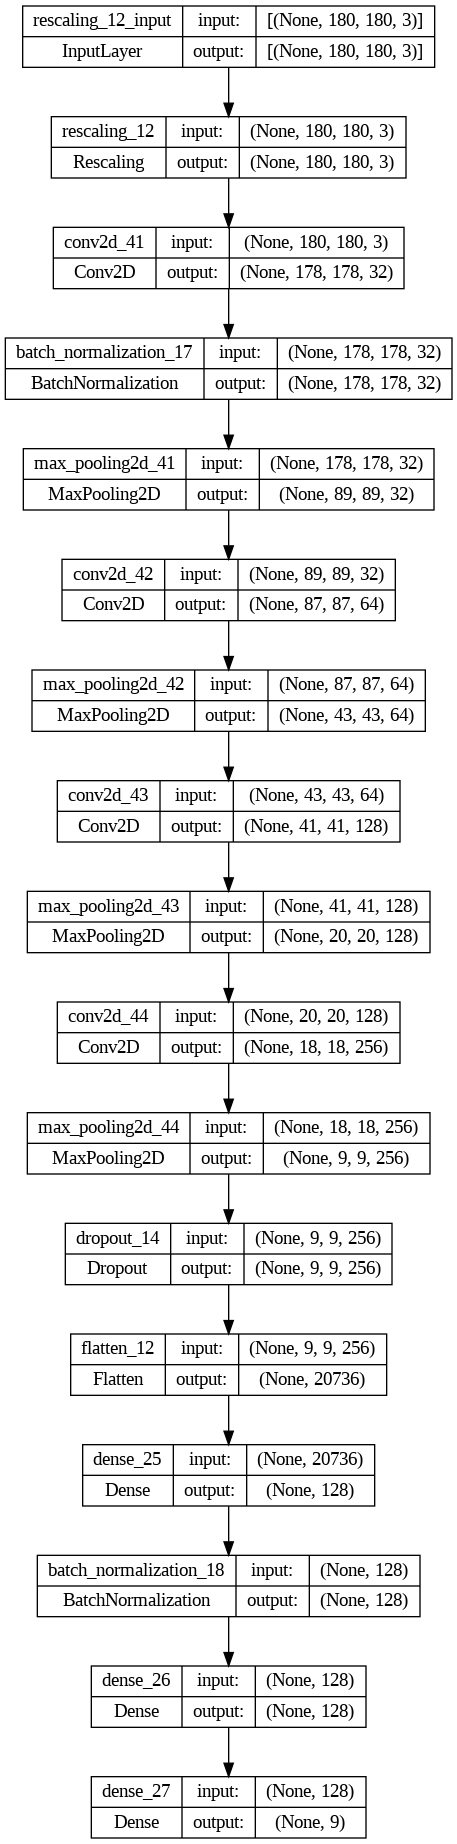

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Compile the Model

In [ ]:


#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

### Train the model

In [ ]:
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/20
169/169 [==============================] - ETA: 0s - loss: 1.5429 - accuracy: 0.4186
Epoch 1: val_accuracy improved from -inf to 0.11507, saving model to model.h5
169/169 [==============================] - 16s 75ms/step - loss: 1.5429 - accuracy: 0.4186 - val_loss: 3.0333 - val_accuracy: 0.1151
Epoch 2/20
169/169 [==============================] - ETA: 0s - loss: 1.2862 - accuracy: 0.5171
Epoch 2: val_accuracy improved from 0.11507 to 0.13586, saving model to model.h5
169/169 [==============================] - 12s 73ms/step - loss: 1.2862 - accuracy: 0.5171 - val_loss: 2.8270 - val_accuracy: 0.1359
Epoch 3/20
169/169 [==============================] - ETA: 0s - loss: 1.1273 - accuracy: 0.5823
Epoch 3: val_accuracy improved from 0.13586 to 0.32665, saving model to model.h5
169/169 [==============================] - 12s 73ms/step - loss: 1.1273 - accuracy: 0.5823 - val_loss: 1.8516 - val_accuracy: 0.3267
Epoch 4/20
169/169 [==============================] - ETA: 0s - loss: 0.9

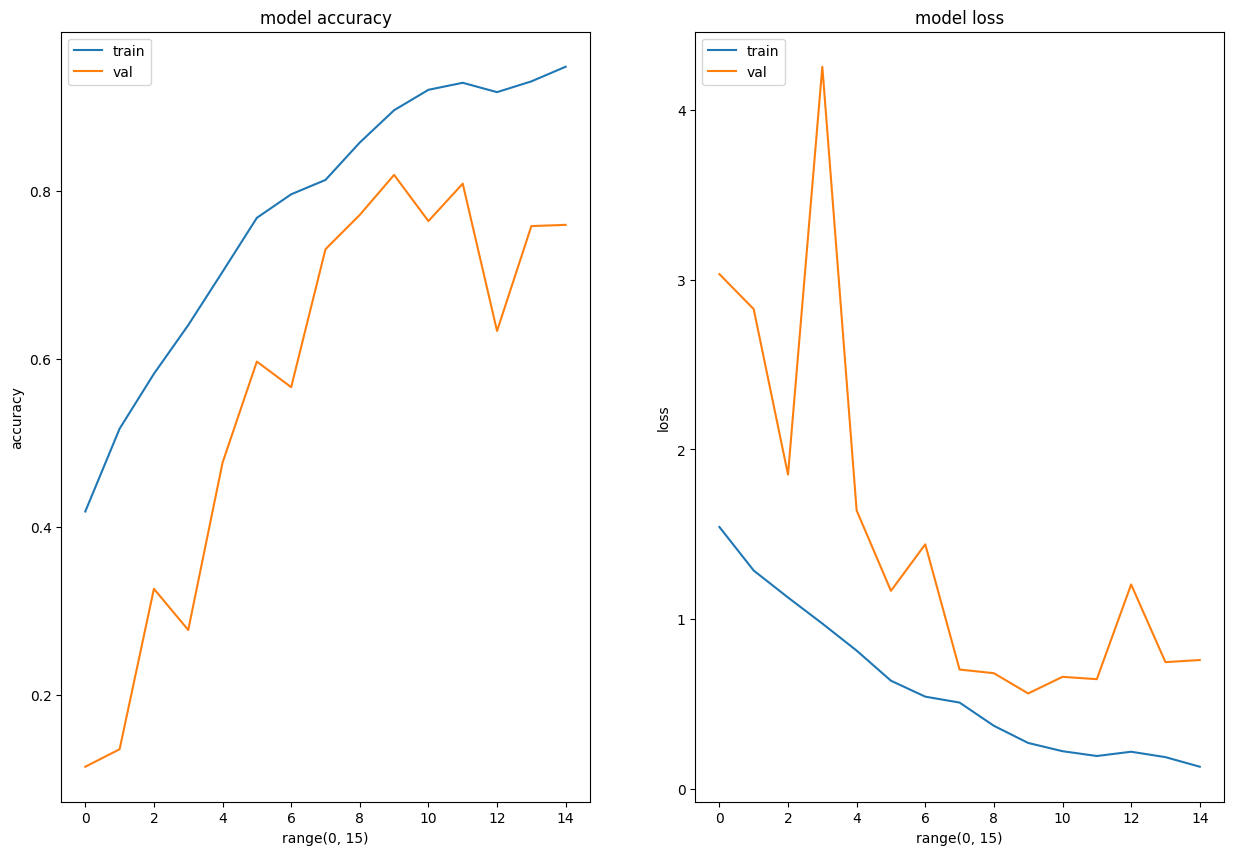

In [ ]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Observations
1. Class Rebalance improved the model performance
2. We can clearly see that overfitting is reduced